# Testing the `graph-tool` library for flow modelling

In [13]:
import graph_tool as gt
import graph_tool.draw
import graph_tool.stats
import itertools as it
import numpy as np
from collections import deque
from random import randint
from math import sqrt

The **organic_flow** graph is the copy of the flow model which is currently displayed in the SandboxCity's Status Quo sankey-diagram (Activity Group level) on the staging server.

In [39]:
G = gt.load_graph("organic_flow.graphml")

The binary format `gt` and the text-based `graphml` are the preferred formats, since they are by far the most complete. Both these formats are equally complete, but the `gt` format is faster and requires less storage.

In [16]:
#G2 = gt.load_graph("random_100k_props.gt")
G2 = gt.load_graph("random_100k_props.graphml")

In [40]:
gt.stats.vertex_average(G, deg="total")

(3.2941176470588234, 0.46885493940357986)

In [25]:
in_hist = gt.stats.vertex_hist(G, deg="total")

In [22]:
gt.stats.vertex_average(G2, deg="total")

(23.89718, 0.052916228895075287)

In [29]:
gt.stats.vertex_average(G2, deg="in")

(11.94859, 0.02757475784334289)

In [30]:
gt.stats.vertex_average(G2, deg="out")

(11.94859, 0.027549926862316717)

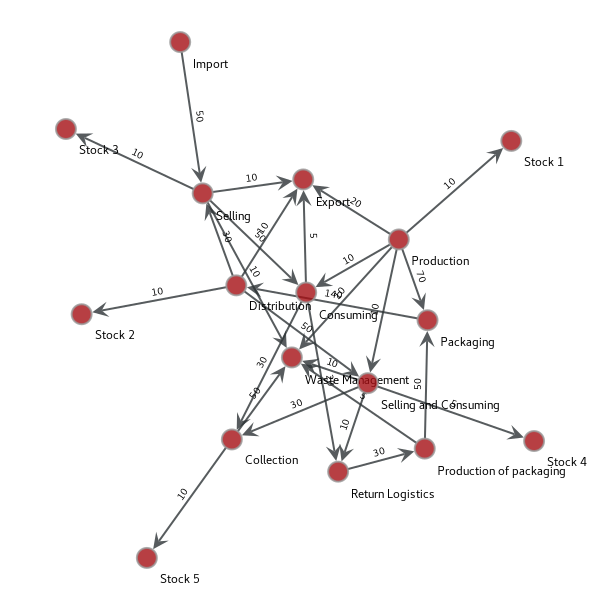

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9395797710, at 0x7f938f2a2b70>

In [38]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vp._graphml_vertex_id,
                  vprops={"text_position":1},
                  edge_text=G.ep.flow,
                  eprops={"font_size":10})

In [24]:
G.vertex_properties.keys()

['_graphml_vertex_id', 'inflow', 'outflow']

In [26]:
G.edge_properties.keys()

['_graphml_edge_id', 'flow']

In [25]:
G.list_properties()

_graphml_vertex_id (vertex)  (type: string)
inflow         (vertex)  (type: int64_t)
outflow        (vertex)  (type: int64_t)
_graphml_edge_id (edge)    (type: string)
flow           (edge)    (type: int64_t)


In [41]:
for v in G.vertices():
    print(v,
          G.vp._graphml_vertex_id[v], 
          "; inflow:", G.vp.inflow[v], 
          "; outflow:", G.vp.outflow[v])

0 Import ; inflow: 0 ; outflow: 50
1 Selling ; inflow: 80 ; outflow: 80
2 Production ; inflow: 0 ; outflow: 130
3 Export ; inflow: 45 ; outflow: 0
4 Waste Management ; inflow: 85 ; outflow: 0
5 Consuming ; inflow: 60 ; outflow: 55
6 Selling and Consuming ; inflow: 60 ; outflow: 55
7 Packaging ; inflow: 120 ; outflow: 140
8 Stock 1 ; inflow: 10 ; outflow: 0
9 Return Logistics ; inflow: 30 ; outflow: 30
10 Collection ; inflow: 60 ; outflow: 60
11 Production of packaging ; inflow: 30 ; outflow: 55
12 Distribution ; inflow: 140 ; outflow: 100
13 Stock 2 ; inflow: 10 ; outflow: 0
14 Stock 4 ; inflow: 5 ; outflow: 0
15 Stock 3 ; inflow: 10 ; outflow: 0
16 Stock 5 ; inflow: 10 ; outflow: 0


In [42]:
for e in G.edges():
    print(e, 
          "; flow:", G.ep.flow[e])

(0, 1) ; flow: 50
(1, 4) ; flow: 10
(1, 3) ; flow: 10
(1, 5) ; flow: 50
(1, 15) ; flow: 10
(2, 3) ; flow: 20
(2, 4) ; flow: 10
(2, 5) ; flow: 10
(2, 6) ; flow: 10
(2, 7) ; flow: 70
(2, 8) ; flow: 10
(5, 9) ; flow: 20
(5, 10) ; flow: 30
(5, 3) ; flow: 5
(6, 14) ; flow: 5
(6, 9) ; flow: 10
(6, 10) ; flow: 30
(6, 4) ; flow: 10
(7, 12) ; flow: 140
(9, 11) ; flow: 30
(10, 4) ; flow: 50
(10, 16) ; flow: 10
(11, 7) ; flow: 50
(11, 4) ; flow: 5
(12, 6) ; flow: 50
(12, 3) ; flow: 10
(12, 1) ; flow: 30
(12, 13) ; flow: 10


## Identifying source and sink Actors

In [43]:
for v in G.vertices():
    #print("node", v)
    nr_out = len(list(v.out_neighbors()))
    nr_in = len(list(v.in_neighbors()))
    #print("nr. out", nr_out)
    if nr_out == 0:
        print(v, G.vp._graphml_vertex_id[v], "is a sink")
    if nr_in == 0:
        print(v, G.vp._graphml_vertex_id[v], "is a source")
    for e in v.out_edges():
        #print("out edge", e)
        pass
    for w in v.out_neighbors():
        #print("out neighbor", w)
        pass

    # the edge and neighbors order always match
    for e, w in zip(v.out_edges(), v.out_neighbors()):
        assert e.target() == w

0 Import is a source
2 Production is a source
3 Export is a sink
4 Waste Management is a sink
8 Stock 1 is a sink
13 Stock 2 is a sink
14 Stock 4 is a sink
15 Stock 3 is a sink
16 Stock 5 is a sink


In [53]:
def get_sources(g):
    """Returns a numpy array"""
    a = g.get_in_degrees(g.get_vertices())
    return np.where(a == 0)[0]

In [54]:
def get_sinks(g):
    """Returns a numpy array"""
    a = g.get_out_degrees(g.get_vertices())
    return np.where(a == 0)[0]

## Test implementation of flow computation in a graph

In [12]:
def compute_stocks(g):
    """Compute the inflow and outflow property of each node"""
    src_nodes = get_sources(g).tolist()
    node_queue = deque(src_nodes)
    nr_v = len(g.get_vertices())
    props = (False for x in range(nr_v))
    vprop_visited = g.new_vertex_property("bool", vals=props)
    g.vertex_properties["visited"] = vprop_visited
    while len(node_queue) > 0:
        n = node_queue[0]
        #print(n)
        #print(G.node[n])
        succ = g.get_out_neighbors(n)
        pred = g.get_in_neighbors(n)
        node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not g.vp.visited[nbr]])
        #print(node_queue)
        out_edges = ((n, out) for out in succ)
        g.vp.outflow[n] = sum((g.ep.flow[edge] for edge in out_edges))
        if len(pred) == 0:
            g.vp.inflow[n] = 0
        else:
            in_edges = ((innode, n) for innode in pred)
            g.vp.inflow[n] = sum((g.ep.flow[edge] for edge in in_edges))
        node_queue.popleft()
        g.vp.visited[n] = True

## Performance test with the organic flow sample graph

In [122]:
G_test = G.copy()

In [123]:
%timeit compute_stocks(G_test)

3.6 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Performance test with a random graph of 100.000 nodes (Actors)

In [17]:
G2_test = G2.copy()

In [18]:
%timeit compute_stocks(G2_test)

1.17 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Flow computation in the GDSE

## 1. Mass balance check

Check if the material-flow is balanced in the graph/system. In other words, the sum of total inflows and the sum of total outflows should be equal.

In [46]:
def mass_balance(g):
    """Sum all in- and outflows in a system
    
    Retruns
    -------
    float
        total inflow - total outflow
    """
    inflow = 0
    outflow = 0
    for v in g.vertices():
        inflow += g.vp.inflow[v]
        outflow += g.vp.outflow[v]
    return float(inflow) - float(outflow)

**`mass_balance()`** returns the signed difference between total *inflow* and *outflow*. Thus if the system is balanced, it returns `0.0`

In [47]:
mass_balance(G)

0.0

## 2. Compute flow-ratios in Status Quo

The flow ratio is computed as $ratio = \frac{outflow}{total\_outflow}$ at each node.
    


In [70]:
def flow_ratio(G):
    """Compute flow-ratios for each material flow
    
    Returns
    -------
    directed graph
        The computed flow ratios added as edge properties
    """
    g = G.copy()
    src_nodes = get_sources(g).tolist()
    node_queue = deque(src_nodes)
    nr_v = len(g.get_vertices())
    props = (False for x in range(nr_v))
    vprop_visited = g.new_vertex_property("bool", vals=props)
    g.vertex_properties["visited"] = vprop_visited
    eprop_ratio = g.new_edge_property("float")
    g.edge_properties["ratio"] = eprop_ratio
    while len(node_queue) > 0:
        n = node_queue[0]
        #print("\n", n, g.vp._graphml_vertex_id[n])
        succ = g.get_out_neighbors(n)
        #print("out neighbors:", succ)
        pred = g.get_in_neighbors(n)
        node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not g.vp.visited[nbr]])
        out_edges = g.get_out_edges(n)
        sum_out = float(sum((g.ep.flow[edge] for edge in out_edges)))
        for edge in out_edges:
            g.ep.ratio[edge] = float(g.ep.flow[edge]) / sum_out
            #print(edge, g.ep.ratio[edge])
        node_queue.popleft()
        g.vp.visited[n] = True
    return g

**flow_ratio()** returns a copy of the graph with the *ratio* property assigned to each edge.

In [69]:
G_r = flow_ratio(G)

## 3. Compute flows in Solutions

Scenario:

1. *Consuming* increases by 20t/year -> *Consuming* in: 80t/year, out: 70t/year
2. *Collection* decreases by 10t/year -> *Collection* in: 50t/year, out: 50t/year
3. *Selling* increases by 20t/year -> *Consuming* in: 100t/year, out: 100t/year

In other words, this use case assumes that during a workshop the in/out attribute of some Activity Groups etc. is changed manually by the users at the Solutions stage. Then the GDSE computes the amounts that will flow in the system

In [93]:
G_s = G_r.copy()
G_s.vp.inflow[5] = 80
G_s.vp.outflow[5] = 70
G_s.vp.inflow[10] = 50
G_s.vp.outflow[10] = 50
G_s.vp.inflow[1] = 100
G_s.vp.outflow[1] = 100

for v in G_s.vertices():
    print(v,
          G_s.vp._graphml_vertex_id[v], 
          "; inflow:", G_s.vp.inflow[v], 
          "; outflow:", G_s.vp.outflow[v])

0 Import ; inflow: 0 ; outflow: 50
1 Selling ; inflow: 100 ; outflow: 100
2 Production ; inflow: 0 ; outflow: 130
3 Export ; inflow: 45 ; outflow: 0
4 Waste Management ; inflow: 85 ; outflow: 0
5 Consuming ; inflow: 80 ; outflow: 70
6 Selling and Consuming ; inflow: 60 ; outflow: 55
7 Packaging ; inflow: 120 ; outflow: 140
8 Stock 1 ; inflow: 10 ; outflow: 0
9 Return Logistics ; inflow: 30 ; outflow: 30
10 Collection ; inflow: 50 ; outflow: 50
11 Production of packaging ; inflow: 30 ; outflow: 55
12 Distribution ; inflow: 140 ; outflow: 100
13 Stock 2 ; inflow: 10 ; outflow: 0
14 Stock 4 ; inflow: 5 ; outflow: 0
15 Stock 3 ; inflow: 10 ; outflow: 0
16 Stock 5 ; inflow: 10 ; outflow: 0


The flows are updated in a 2 iterations:

1. Compute the material amount of every flow from the previously computed flow-ratios (in Status Quo) and the *outflow* property of a node, as $flow = ratio\times outflow$

2. Compute the *inflow* of each node as the sum of all incoming flows

Thus, the *inflow* and *outflow* property of a node (Actor) is a bit confusing, because the *inflow* of a node does not directly determine its *outflow*. In fact, users are expected to adjust only the *outflows* of Actors during a workshop.

In [105]:
def compute_flows(G):
    """Compute the amount of flow for each edge and inflow for each node"""
    g = G.copy()
    assert 'ratio' in g.edge_properties.keys(), "missing edge property 'ratio'"
    assert 'outflow' in g.vertex_properties.keys(), "missing vertex property 'outflow'"
    assert 'inflow' in g.vertex_properties.keys(), "missing vertex property 'inflow'"
    src_nodes = get_sources(g).tolist()
    node_queue = deque(src_nodes)
    nr_v = len(g.get_vertices())
    props = (False for x in range(nr_v))
    vprop_visited = g.new_vertex_property("bool", vals=props)
    # First update the flows, based on the 'outflow' of each node
    print("\n Updading flows")
    while len(node_queue) > 0:
        n = node_queue[0]
        print("\n", n, g.vp._graphml_vertex_id[n])
        succ = g.get_out_neighbors(n)
        pred = g.get_in_neighbors(n)
        node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not vprop_visited[g.vertex(nbr)]])
        out_edges = g.get_out_edges(n)
        for edge in out_edges:
            f = float(g.ep.flow[edge])
            r = g.ep.ratio[edge] * float(g.vp.outflow[n])
            if abs(f - r) > 0.0001:
                print("updating flow on edge:", edge, "value:", f)
                g.ep.flow[edge] = r
                print("new value:", g.ep.flow[edge])
        node_queue.popleft()
        vprop_visited[g.vertex(n)] = True
    # Then update the 'inflow' of each Actor, based on the flows
    print("\n Updading inflows")
    vprop_visited.a = False
    node_queue = deque(src_nodes)
    while len(node_queue) > 0:
        n = node_queue[0]
        print("\n", n, g.vp._graphml_vertex_id[n])
        succ = g.get_out_neighbors(n)
        pred = g.get_in_neighbors(n)
        if len(pred) == 0:
            node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not vprop_visited[g.vertex(nbr)]])
            node_queue.popleft()
            vprop_visited[g.vertex(n)] = True
        else:
            node_queue.extend([nbr for nbr in succ if nbr not in node_queue and not vprop_visited[g.vertex(nbr)]])
            in_edges = g.get_in_edges(n)
            print("updating inflow, current value:", g.vp.inflow[n])
            g.vp.inflow[n] = sum((g.ep.flow[edge] for edge in in_edges))
            print("new value:", g.vp.inflow[n])
            node_queue.popleft()
            vprop_visited[g.vertex(n)] = True
    return g

**compute_flows()** returns a copy of a graph with updated *flow* edge-properties and updated *inflow* vertex-properties.

In [106]:
G_t = compute_flows(G_s)


 Updading flows

 0 Import

 2 Production

 1 Selling
updating flow on edge: [1 4 1] value: 10.0
new value: 12
updating flow on edge: [1 3 2] value: 10.0
new value: 12
updating flow on edge: [1 5 3] value: 50.0
new value: 62
updating flow on edge: [ 1 15  4] value: 10.0
new value: 12

 3 Export

 4 Waste Management

 5 Consuming
updating flow on edge: [ 5  9 11] value: 20.0
new value: 25
updating flow on edge: [ 5 10 12] value: 30.0
new value: 38
updating flow on edge: [ 5  3 13] value: 5.0
new value: 6

 6 Selling and Consuming

 7 Packaging

 8 Stock 1

 15 Stock 3

 9 Return Logistics

 10 Collection
updating flow on edge: [10  4 20] value: 50.0
new value: 41
updating flow on edge: [10 16 21] value: 10.0
new value: 8

 14 Stock 4

 12 Distribution

 11 Production of packaging

 16 Stock 5

 13 Stock 2

 Updading inflows

 0 Import

 2 Production

 1 Selling
updating inflow, current value: 100
new value: 80

 3 Export
updating inflow, current value: 45
new value: 48

 4 Waste Manage

In [104]:
mass_balance(G_t)

-4.0